In [9]:
import gc
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

glob.glob('../input/*/*')

['../input/plant-pathology/sample_submission.csv',
 '../input/plant-pathology/train.csv',
 '../input/plant-pathology/test',
 '../input/plant-pathology/train']

In [2]:
DATA_PATH = '../input/plant-pathology/'
df_train = pd.read_csv(Path(DATA_PATH).joinpath('train.csv'))

In [3]:
df_train.head()

,image,labels,answer
0,44tiw9rcjr6f30ytb3qh.jpg,scab,0
1,6p93kmnoeh9petqkeat5.jpg,healthy,1
2,y7da7kwc7pv0do2hcb0t.jpg,healthy,1
3,jcocgsc12z4e8fle501y.jpg,scab,0
4,ztyq9ko4pxs3taeoz8nj.jpg,healthy,1


In [4]:
df_test = pd.read_csv(Path(DATA_PATH).joinpath('sample_submission.csv'))
df_test.head()

,image,answer
0,hg3oun3bcgvzuw7ojgpw.jpg,0
1,b1j0auyg7bpbo8mivsl2.jpg,0
2,vtglgbrfqixttb8gkzha.jpg,0
3,yu1o21vs157e94l2hm09.jpg,0
4,897106j7hshv5sdrodlq.jpg,0


In [5]:
df_train.labels.value_counts()

scab                  2621
healthy               2591
frog_eye_leaf_spot    1575
rust                  1213
Name: labels, dtype: int64

In [6]:
df_train.answer.unique()

array([0, 1, 3, 2])

In [7]:
from sklearn.model_selection import train_test_split

TRAIN_IMG_PATH = Path(DATA_PATH).joinpath('train')
TEST_IMG_PATH = Path(DATA_PATH).joinpath('test')

df_train.answer = df_train.answer.astype('str')
df_train = df_train[['image', 'answer']]
df_test = df_test[['image']]

print('train set shape:', df_train.shape)
print('test set shape', df_test.shape)

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size=0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]


train set shape: (8000, 2)
test set shape (8221, 1)


In [8]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=TRAIN_IMG_PATH,
    x_col='image',
    y_col='answer',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

valid_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=TRAIN_IMG_PATH,
    x_col='image',
    y_col='answer',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_IMG_PATH,
    x_col='image',
    y_col=None,
    target_size=img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 6400 validated image filenames belonging to 4 classes.
Found 1600 validated image filenames belonging to 4 classes.
Found 8221 validated image filenames.


In [10]:
resnet_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
# resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step


In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax', kernel_initializer='he_normal'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
def get_steps(num_samples, batch_size):
    if (num_samples%batch_size) > 0:
        return (num_samples//batch_size) + 1
    else:
        return num_samples//batch_size


In [14]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

# ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = valid_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
200/200 [==============================] - 101s 462ms/step - loss: 0.7796 - acc: 0.7305 - val_loss: 23.7807 - val_acc: 0.5381
Epoch 2/20
200/200 [==============================] - 60s 298ms/step - loss: 0.2788 - acc: 0.9071 - val_loss: 0.6514 - val_acc: 0.8512
Epoch 3/20
200/200 [==============================] - 59s 294ms/step - loss: 0.1541 - acc: 0.9471 - val_loss: 0.9201 - val_acc: 0.8238
Epoch 4/20
200/200 [==============================] - 59s 293ms/step - loss: 0.1283 - acc: 0.9581 - val_loss: 0.5216 - val_acc: 0.8556
Epoch 5/20
200/200 [==============================] - 59s 297ms/step - loss: 0.1666 - acc: 0.9473 - val_loss: 13.3647 - val_acc: 0.5706
Epoch 6/20
200/200 [==============================] - 59s 296ms/step - loss: 0.1819 - acc: 0.9419 - val_loss: 0.2914 - val_acc: 0.9106
Epoch 7/20
200/200 [==============================] - 60s 299ms/step - loss: 0.1524 - acc: 0.9522 - val_loss: 0.3414 - val_acc: 0.9000
Epoch 8/20
200/200 [==============================] 

147

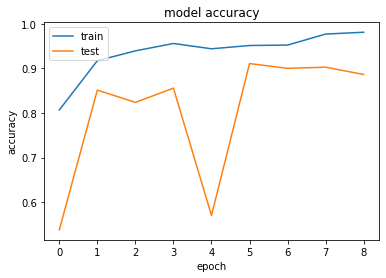

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
test_generator.reset()
pred = model.predict_generator(
    generator=test_generator,
    steps=get_steps(nb_test_samples, batch_size),
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


257/257 [==============================] - 86s 331ms/step


In [17]:
pred_class_indices=np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in pred_class_indices]

submission = pd.read_csv(Path(DATA_PATH).joinpath('sample_submission.csv'))
submission['answer'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,image,answer
0,hg3oun3bcgvzuw7ojgpw.jpg,3
1,b1j0auyg7bpbo8mivsl2.jpg,1
2,vtglgbrfqixttb8gkzha.jpg,0
3,yu1o21vs157e94l2hm09.jpg,0
4,897106j7hshv5sdrodlq.jpg,0
